# Telco Churn Prediction: Data Ingestion and EDA

## 1. Introduction

### 1.1 Project Goal & Analysis

The primary objective of this investigation is to identify the main drivers for customer's churning. This allows the necessary teams to target and design strategies which will prevent churning. This analysis is the foundation for building a robust predictive classification model that will reduce Customer Lifetime Value (CLV) loss.

In this notebook we will prepare the raw data via loading, cleaning, validating and understanding the key patterns.

## 2. Initial Setup

### 2.1 Library Imports and Configurations

In [1]:
#Import necessary libraries
import pandas as pd
import sys
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from data.load_data import load_and_prepare
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Display settings allow complete dataframe columns to be seen
pd.set_option('display.max_columns', None)
sns.set(style="whitegrid")

### 2.2 Load Raw Data and Schema Validation

In [2]:
churn_df = load_and_prepare("../data/raw/Telco-Customer-Churn.csv")

### 2.3 Data Structure and Types Inspection

The below gives us an idea of the different columns and values.

In [3]:
churn_df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
churn_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   customerID        7043 non-null   string  
 1   gender            7043 non-null   category
 2   SeniorCitizen     7043 non-null   category
 3   Partner           7043 non-null   category
 4   Dependents        7043 non-null   category
 5   tenure            7043 non-null   Int64   
 6   PhoneService      7043 non-null   category
 7   MultipleLines     7043 non-null   category
 8   InternetService   7043 non-null   category
 9   OnlineSecurity    7043 non-null   category
 10  OnlineBackup      7043 non-null   category
 11  DeviceProtection  7043 non-null   category
 12  TechSupport       7043 non-null   category
 13  StreamingTV       7043 non-null   category
 14  StreamingMovies   7043 non-null   category
 15  Contract          7043 non-null   category
 16  PaperlessBilling  7043 n

Examining the head and info of the churn_df, we see that a lot of the columns can be classed as categorical and columns such as 'TotalCharges' need to be converted to int/float format, this is done within src -> data -> column_schema.py, load_data.py, schema_validation.py and type_utils.py scripts.

In [5]:
churn_df.describe()

,tenure,MonthlyCharges,TotalCharges
count,7043.0,7043.000000,7032.000000
mean,32.371149,64.761692,2283.300441
std,24.559481,30.090047,2266.771362
min,0.0,18.250000,18.800000
25%,9.0,35.500000,401.450000
50%,29.0,70.350000,1397.475000
75%,55.0,89.850000,3794.737500
max,72.0,118.750000,8684.800000


## 3 Data Quality Checks

It is important to also look out for any duplicate values that may provide false outcomes with the model. Observing the below table we successfully find no duplicates.

In [6]:
churn_df[churn_df.duplicated()]


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn


When cleaning data is important to inspect for null values and deal with correctly, as it can cause issues further down the line in analysis or modelling, where it is not an accepted parameter in models, it can skew statistics and affect quality of data.

In [7]:
# Understand missing values
missing = churn_df.isnull().sum()
percent_missing = (missing / churn_df.shape[0]) * 100
pd.DataFrame({'missing_count': missing, 'missing_percent': percent_missing})

,missing_count,missing_percent
customerID,0,0.000000
gender,0,0.000000
SeniorCitizen,0,0.000000
Partner,0,0.000000
Dependents,0,0.000000
tenure,0,0.000000
PhoneService,0,0.000000
MultipleLines,0,0.000000
InternetService,0,0.000000
OnlineSecurity,0,0.000000


In [8]:
churn_df[churn_df['TotalCharges'].isnull()]

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,4472-LVYGI,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,NaN,No
753,3115-CZMZD,Male,0,No,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,NaN,No
936,5709-LVOEQ,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,NaN,No
1082,4367-NUYAO,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,NaN,No
1340,1371-DWPAZ,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,NaN,No
3331,7644-OMVMY,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,NaN,No
3826,3213-VVOLG,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,NaN,No
4380,2520-SGTTA,Female,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,NaN,No
5218,2923-ARZLG,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,NaN,No
6670,4075-WKNIU,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,NaN,No


The above highlights values of which 'TotalCharges' were not recorded. Examining the other columns we see that the column 'tenure' has 0 for all values. This suggests that the customers are new to the network and as a result will not have been charged. To deal with this we simply replace NaN with 0.

In [9]:
churn_df['TotalCharges'] = churn_df['TotalCharges'].fillna(0)

Using .unique we can understand for the services offered by the network how many different values there are. For example Internet Service shows three options whereas Partner is a simple Yes and No.

In [10]:
churn_df["OnlineBackup"].unique()

['Yes', 'No', 'No internet service']
Categories (3, string): [No, No internet service, Yes]

With .nunique earlier, we had a look at the various values for columns. Having gathered this information we can check categorical columns, to see whether they are binary.

In [11]:
binary_cols = [col for col in churn_df.columns if churn_df[col].nunique() == 2]

In [12]:
binary_cols

['gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'PhoneService',
 'PaperlessBilling',
 'Churn']

In [13]:
churn_df.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

Comparing the above we see that columns: 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV' and 'StreamingMovies' are potential binary columns which have extra 'No internet service' category.

From the unique values examined for the serices, we see that outputs included "No internet service" and "No phone service", these can simply be converted to "No", giving simpler, binary outputs.

In [14]:
cols = [
    "OnlineSecurity", "OnlineBackup", "DeviceProtection",
    "TechSupport", "StreamingTV", "StreamingMovies"
]

for col in cols:
    churn_df[col] = churn_df[col].astype(str).replace({"No internet service": "No"})

churn_df["MultipleLines"] = (
    churn_df["MultipleLines"].astype(str).replace({"No phone service": "No"})
)

## 4. Target Variable Exploration

The below figure shows that ~25% of individuals have churned in this dataset.

It is important that we understand the distribution of individuals that Churn as an inbalanced distribution will lead to evaluation frameworks such as accuracy being useless, as if not churn is predicted every time for below data set, it would give a high accuracy. Additionally, we know that when splitting the dataset, it needs to be stratified to avoid test set not having any churn individuals.

From a business impact point of view, we can understand the cost of retention efforts vs the loss of churned customers. 

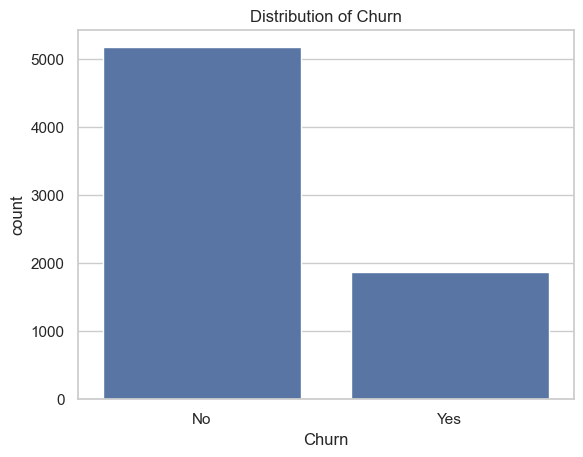

Churn
No     73.463013
Yes    26.536987
Name: proportion, dtype: float64

In [15]:
# Target variable: Churn
sns.countplot(x='Churn', data=churn_df)
plt.title("Distribution of Churn")
plt.show()

# Percentage
churn_df['Churn'].value_counts(normalize=True) * 100

The above plot of churn to no churn helps us to understand that how many users we expect the model to predict will churn. It also enables us to understand the correct evaluation metrics as using accuracy for example would not be representative for this imbalanced result. 



## 5. Univariate Analysis

Understanding Features - Categorical and numerical column analysis

In [16]:
categorical_cols = churn_df.select_dtypes(include=['category']).columns.tolist()
categorical_cols.remove('Churn')       # target handled separately

numeric_cols = churn_df.select_dtypes(include=['int64', 'float64']).columns.tolist()

print("Categorical columns:", categorical_cols)
print("Numeric columns:", numeric_cols)

Categorical columns: ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'InternetService', 'Contract', 'PaperlessBilling', 'PaymentMethod']
Numeric columns: ['tenure', 'MonthlyCharges', 'TotalCharges']


### 5.1 Numerical Checks

In [17]:
# Summary statistics
churn_df[numeric_cols].describe()

,tenure,MonthlyCharges,TotalCharges
count,7043.0,7043.000000,7043.000000
mean,32.371149,64.761692,2279.734304
std,24.559481,30.090047,2266.794470
min,0.0,18.250000,0.000000
25%,9.0,35.500000,398.550000
50%,29.0,70.350000,1394.550000
75%,55.0,89.850000,3786.600000
max,72.0,118.750000,8684.800000


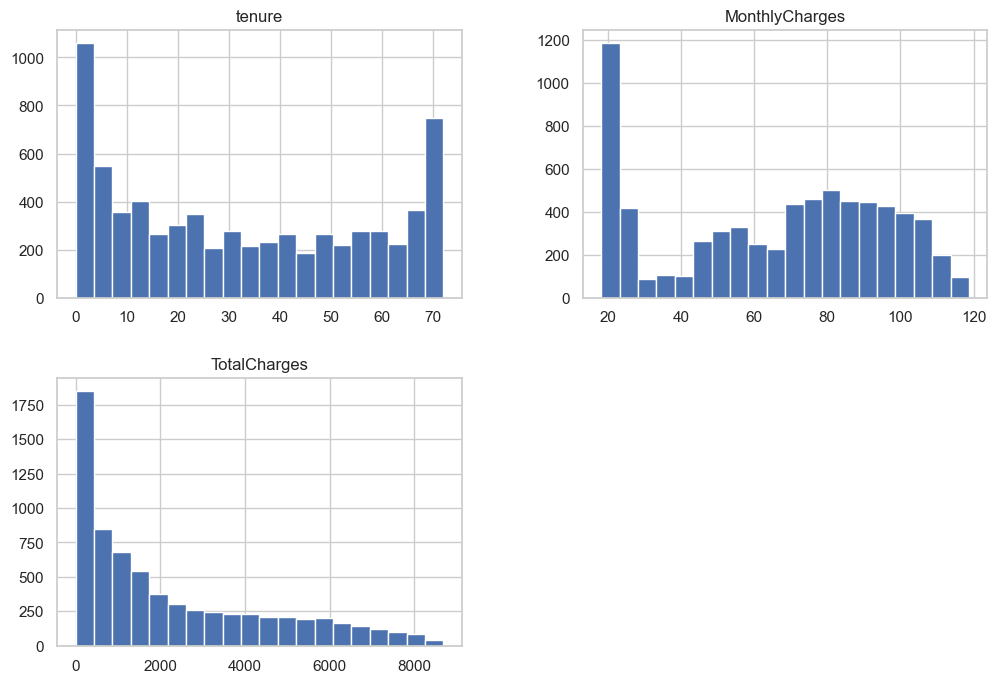

In [18]:
# Visualize distributions
churn_df[numeric_cols].hist(bins=20, figsize=(12,8))
plt.show()

Studying the histograms above, for tenure we see two peaks one at the beginning from 0-3 months and towards the end ~70 months. We understand that there is a large number of new customers and large number of loyal long-term customers. It is important to keep in mind when analysing that we want to retain customers particularly this large amount of new customers to stay on and not churn. 

For Monthly Charges, we can see a huge peak at the lower end, suggesing many customers have simple contracts that do not include additional services. Furthermore a few peaks are seen around the centre suggesting there is also customer segments that include services within their contract. 

Total charges show a clear positive skew, highlighting that there could be a high churn since a longer tenure would lead to higher total charges.

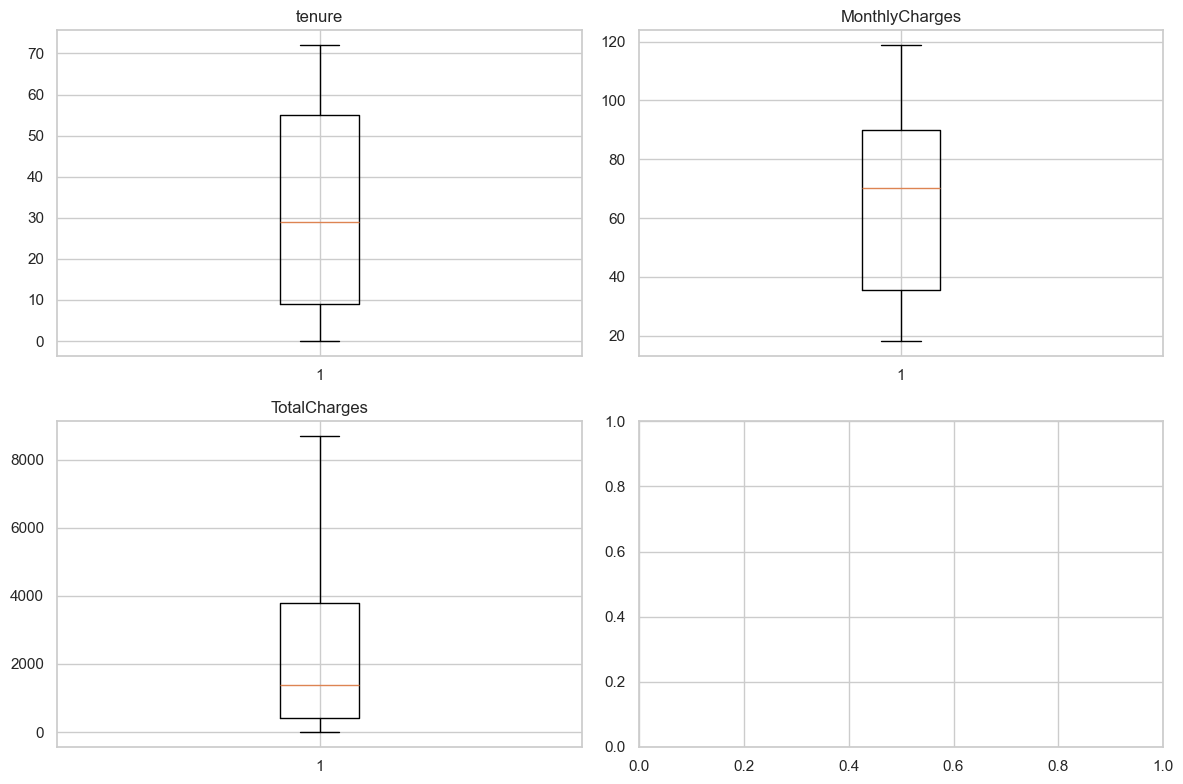

In [19]:
num_cols = len(numeric_cols)
ncols = 2  # number of plots per row
nrows = (num_cols + 1) // ncols

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 8))

axes = axes.flatten()  # flatten to 1D so it's easier to index

for ax, col in zip(axes, numeric_cols):
    ax.boxplot(churn_df[col].dropna())
    ax.set_title(col)

plt.tight_layout()
plt.show()


For tenure the median is relatively centered, and whiskers extend close to the min (1) and max (72), indicating a balanced spread across the high and low-tenure groups, with no extreme outliers.

Analysing the monthly charges the median is shown to be close to the center of the box, and the whiskers are of similar length, indicating the distribution is fairly symmetric with no significant skew or severe outliers.

The total charges, has a relatively low median, which can be explained by large number of new, low-tenure customers causing the median to be lower. As indicated by the histogram above, a positive skew can be seen through the box and top whisker being longer than the bottom equivalent.

### 5.2 Categorical Checks

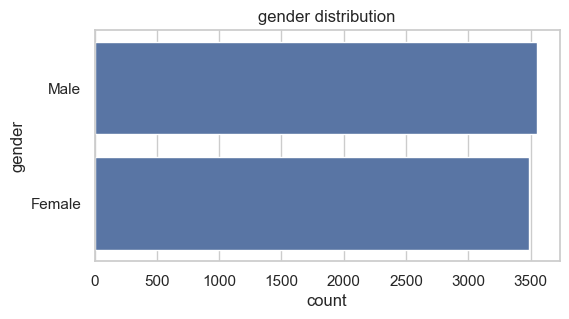

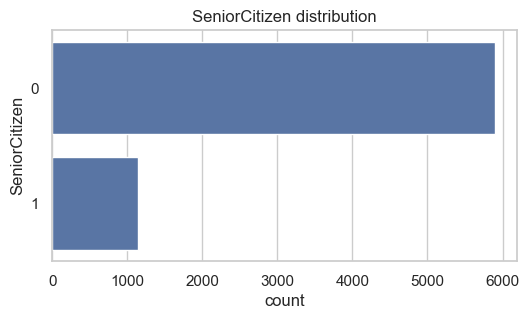

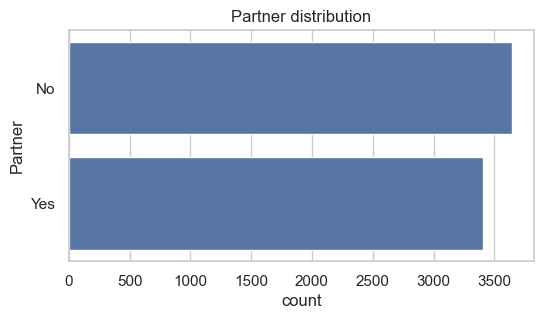

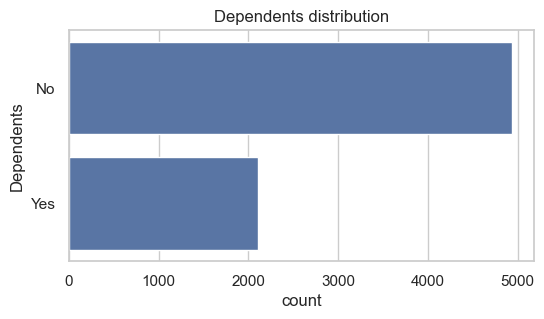

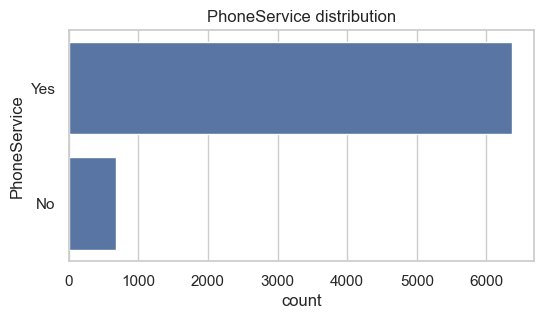

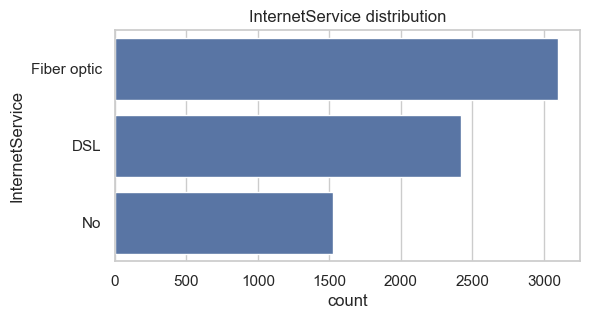

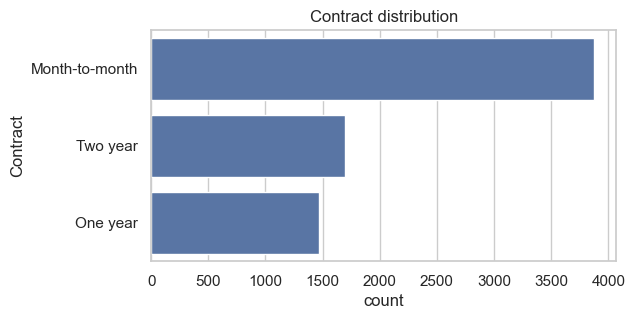

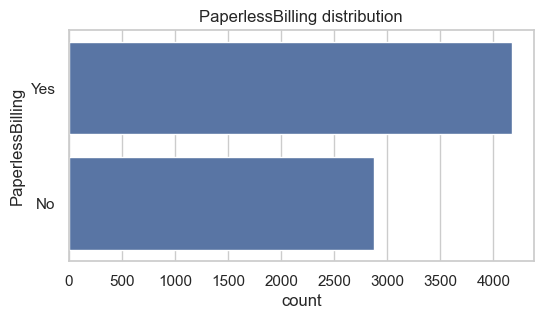

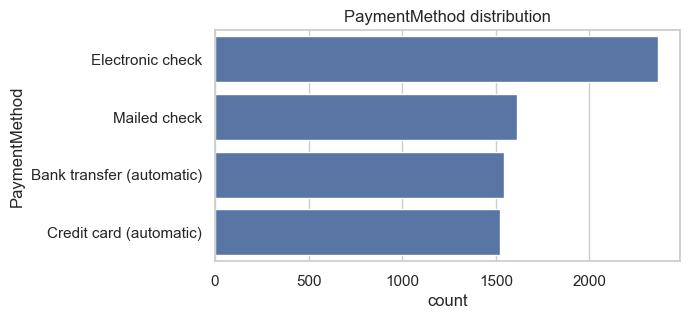

In [20]:
for col in categorical_cols:
    plt.figure(figsize=(6,3))
    sns.countplot(y=col, data=churn_df, order=churn_df[col].value_counts().index)
    plt.title(f"{col} distribution")
    plt.show()

Looking through the above plots, a well balanced distribution can be seen for gender and having a partner. For some of the binary columns an inbalance is seen where categories "Streaming Movie distribution", "Streaming TV distribtion", "Tech Support distribution", "Dependents distribution" and a few other column show a greater amount of No use of service compared to usage. This is important as the imbalance which exisits in these classes may provide less predictive power if not represented well.

## 6. Bivariate Analysis

We then proceed onto bivariate analysis which has the added advantage of understanding the correlation or dependency between the predictor values we are investigating and the target value (Churn or not), giving us an indication of feature relevance.

### 6.1 Numeric Features vs Churn

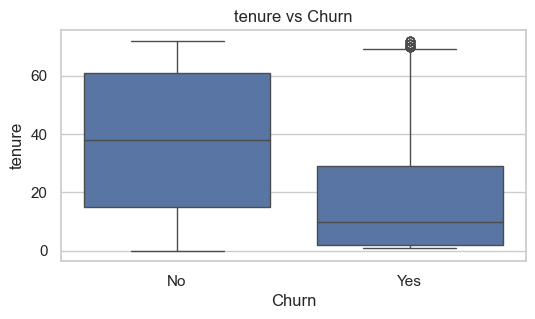

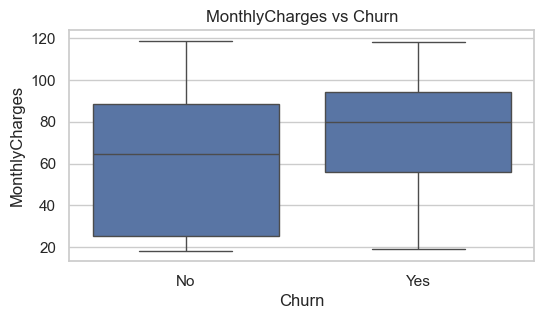

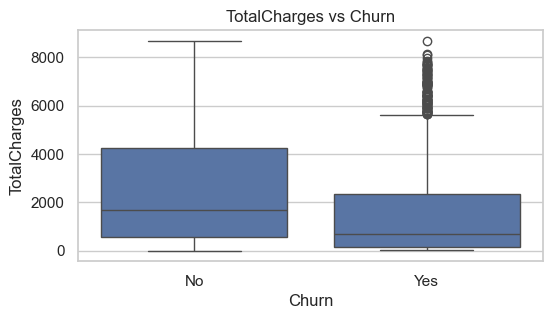

In [21]:
for col in numeric_cols:
    plt.figure(figsize=(6,3))
    sns.boxplot(x='Churn', y=col, data=churn_df)
    plt.title(f"{col} vs Churn")
    plt.show()

Observing the above boxplot, customers with a low tenure show a strong tendency to churn. Understandably, with higher monthly charges we see a greater amount of individual churning. In result looking at total charges it makes sense that with a higher churn there will likely be a lower total charge.

### 6.2 Categorical Features vs Churn

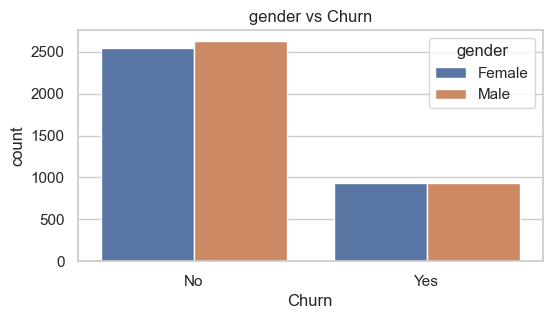

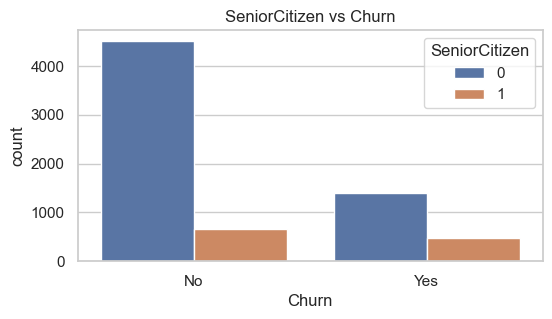

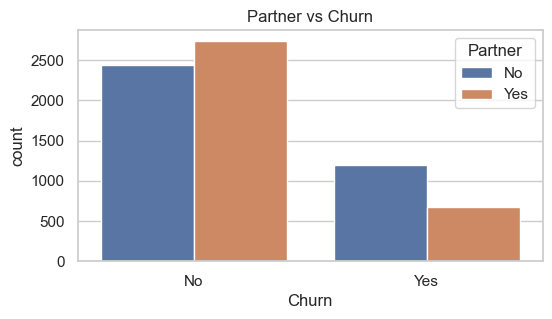

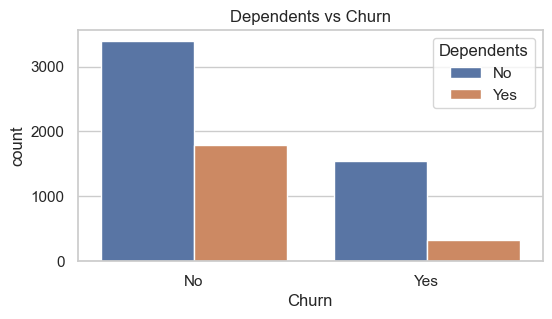

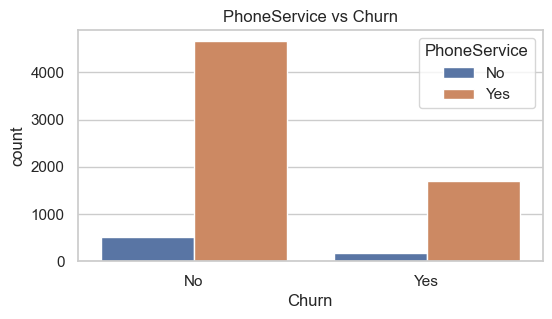

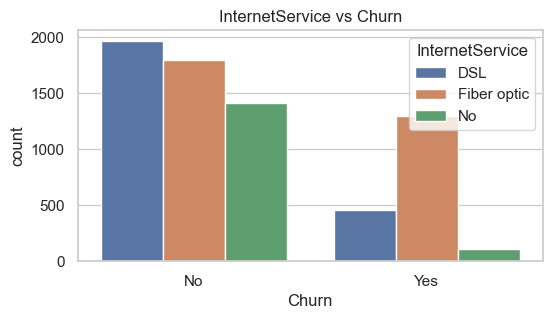

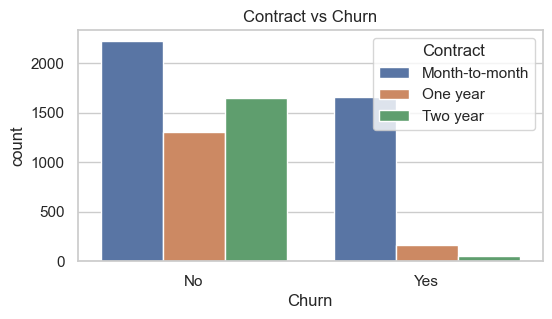

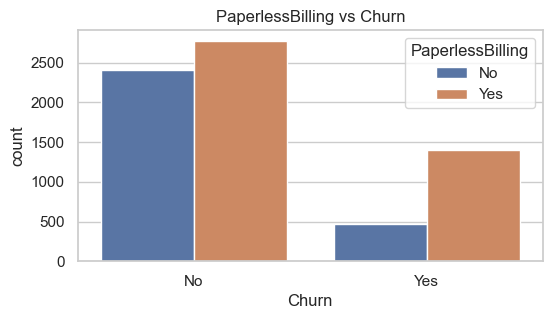

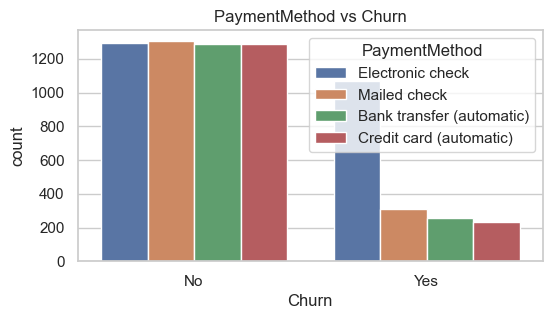

In [22]:
for col in categorical_cols:
    plt.figure(figsize=(6,3))
    sns.countplot(x='Churn', hue=col, data=churn_df)
    plt.title(f"{col} vs Churn")
    plt.show()

For the categorical feature vs churn, from the above charts, we see that churn is high where the internet service is FibreOptic, where the contract type is month to month, where an electronic check is used and when paperless billing is used. 

## 7. Multivariate Analysis

Multivariate analysis helps us to understand how multiple variables interact with each other.

### 7.1 Correlation Matrix

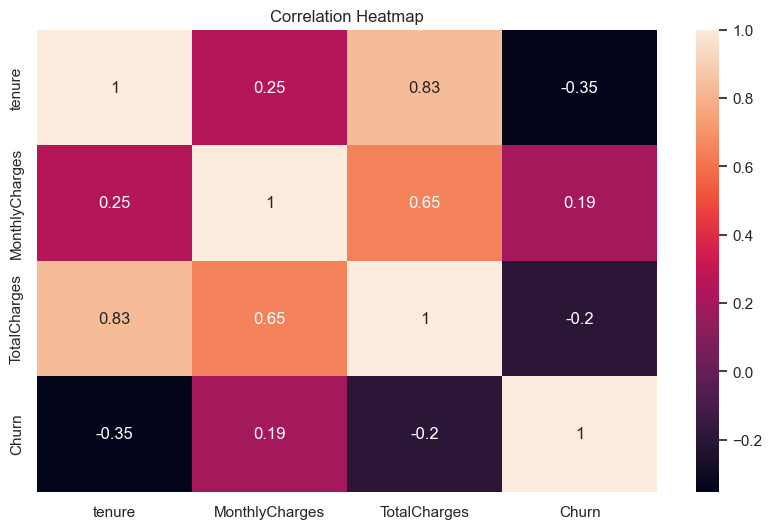

In [23]:
churn_df['Churn'] = churn_df['Churn'].map({'Yes':1,'No':0})

plt.figure(figsize=(10,6))
sns.heatmap(churn_df[numeric_cols + ['Churn']].corr(), annot=True)
plt.title("Correlation Heatmap")
plt.show()


The above graph shows a high correlation value of 0.83 between tenure and total charges, which as mentioned previously is understandable as a high tenure will lead to greater total charges. Monthly charges and total charges displays a high correlation of 0.65.

### 7.2 Correlation with Target

In [24]:
corr_with_target = churn_df[numeric_cols + ['Churn']].corr()['Churn'].sort_values(ascending=False)
corr_with_target

Churn             1.000000
MonthlyCharges    0.193356
TotalCharges     -0.198324
tenure           -0.352229
Name: Churn, dtype: float64

The Churn columns shows highest negative correlation with tenure, which suggests that long term customers are less likely to churn (new customers churn more). Looking at this in a business perspective this is important as long as customers stay on for a minimum period of time and are satisfied with service it is likely they will continue on.

### 7.3 Multicollinearity Check (Variance Inflation Factor Check)

Multicollinearity occurs when two or more predictor (independent) variables in a regression model are highly correlated with each other. The VIF for a predictor measures how much the variance of the estimated regression coefficient is increased due to collinearity with the other predictors in the model.

In [25]:
X = churn_df[numeric_cols].dropna()

vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values.astype(float), i) for i in range(X.shape[1])]
vif_data

,feature,VIF
0,tenure,6.332328
1,MonthlyCharges,3.355660
2,TotalCharges,8.075070


VIF between between 5 and 10, as shown by tenure and TotalCharges suggesting multicollinearity might be a concern and warrants investigation/remedial action. This can be seen highest for total charges, which makes sense as it is essentially the product of tenure and MonthlyCharges. Therefore, it is important that remedial techniuqes such as removing one of these highly correlated variables since introducing significant multicollinearity can make the model's coefficient estimate unstable.

## 8 Outlier Detection 

### 8.1 IQR

In [26]:
outlier_summary = {}

for col in numeric_cols:
    Q1 = churn_df[col].quantile(0.25)
    Q3 = churn_df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    
    outliers = churn_df[(churn_df[col] < lower) | (churn_df[col] > upper)]
    
    outlier_summary[col] = len(outliers)

outlier_summary


{'tenure': 0, 'MonthlyCharges': 0, 'TotalCharges': 0}

The numeric features exhibit no significant outliers. All numeric features (tenure, MonthlyCharges, TotalCharges) show no statistical outliers. Therefore, no outlier removal or capping is required.

## 9 Summary

### 9.1 Key Findings from EDA

#### 1. The Target Variable (Churn)

The dataset exhibits class imbalance, with around 25% of the customers having churned.

This imbalance is a critical finding, as it suggests that standard accuracy metrics may be misleading, and the model training process (e.g., data splitting) should be stratified to ensure proper representation in the test set.

#### 2. Data Quality and Preprocessing

Missing Values: Only the TotalCharges column had missing values (11 records). These missing records corresponded to customers with a tenure of 0 (brand-new customers).

Duplicates: No duplicate customer records were found in the dataset.

Categorical Cleaning: Several columns, such as service features (OnlineSecurity, TechSupport, etc.), contained values like "No internet service" or "No phone service" which were converted to a simpler "No" to streamline them into binary features for modeling.

#### 3. Numerical Feature Distributions

tenure: The distribution is fairly balanced across high and low-tenure groups, without extreme outliers.

MonthlyCharges: The distribution is fairly symmetric with no significant skew or severe outliers.

TotalCharges: The distribution displays a positive skew and a relatively low median. This shape is a result of a large number of new, low-tenure customers who have not yet accumulated high total charges.

## 10 Export Data

### 10.1 Save cleaned dataset

In preparation of moving onto the next phase we drop columns not required such as customerID, which has no predicitve relevance.

In [27]:
df_clean = churn_df.drop(['customerID'], axis=1)

In [28]:
df_clean.to_csv("../data/processed/churn_clean.csv", index=False)